# Knowledge Graph

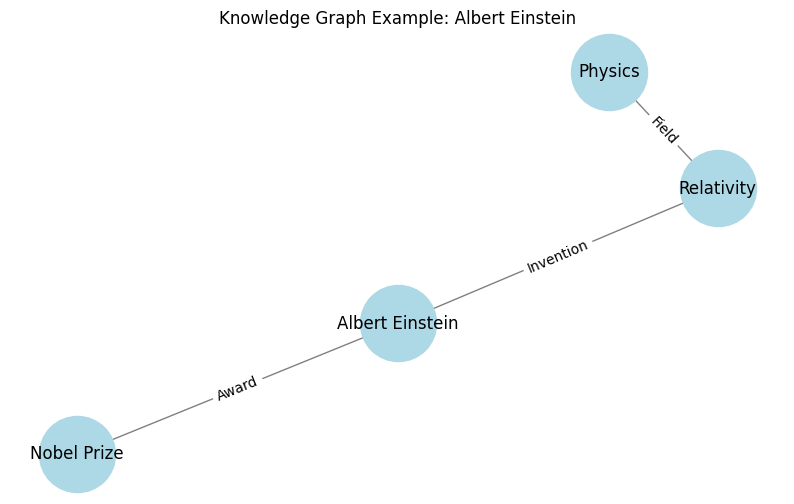

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# 지식 그래프 생성
G = nx.DiGraph()

# 노드 추가 (엔티티)
G.add_node("Albert Einstein")
G.add_node("Relativity")
G.add_node("Physics")
G.add_node("Nobel Prize")

# 엣지 추가 (관계)
G.add_edge("Albert Einstein", "Relativity", label="Invention")
G.add_edge("Albert Einstein", "Nobel Prize", label="Award")
G.add_edge("Relativity", "Physics", label="Field")

# 그래프 시각화
pos = nx.spring_layout(G)  # 노드 위치 설정
plt.figure(figsize=(10, 6))

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=3000, node_color='lightblue')

# 엣지 그리기
nx.draw_networkx_edges(G, pos, edge_color='gray', arrowstyle='->', arrowsize=20)

# 노드 레이블 그리기
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# 엣지 레이블 그리기
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# 그래프 출력
plt.title("Knowledge Graph Example: Albert Einstein")
plt.axis('off')  # 축 제거
plt.show()


# OpenAI gpt-4o-mini usage

In [3]:
from openai import OpenAI
import json
import os

file_path = '../../API_keys/keys.json'
with open(file_path, 'r') as file:
    api = json.load(file)
os.environ["OPENAI_API_KEY"] = api['openai']

client = OpenAI()

completion = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "You are a helpful assistant."},
        {
            "role": "user",
            "content": "Write a haiku about recursion in programming."
        }
    ]
)

print(completion.choices[0].message)

ChatCompletionMessage(content='Lines of code unfold,  \nCalling back into itself,  \nEndless loops of thought.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)


# smolagents usage

## text embedding for RAG

In [1]:
import datasets
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.retrievers import BM25Retriever

knowledge_base = datasets.load_dataset("m-ric/huggingface_doc", split="train")
knowledge_base = knowledge_base.filter(lambda row: row["source"].startswith("huggingface/transformers"))

source_docs = [
    Document(page_content=doc["text"], metadata={"source": doc["source"].split("/")[1]})
    for doc in knowledge_base
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)
docs_processed = text_splitter.split_documents(source_docs)

## Set Retriever Tool

In [2]:
from smolagents import Tool

class RetrieverTool(Tool):
    name = "retriever"
    description = "Uses semantic search to retrieve the parts of transformers documentation that could be most relevant to answer your query."
    inputs = {
        "query": {
            "type": "string",
            "description": "The query to perform. This should be semantically close to your target documents. Use the affirmative form rather than a question.",
        }
    }
    output_type = "string"

    def __init__(self, docs, **kwargs):
        super().__init__(**kwargs)
        self.retriever = BM25Retriever.from_documents(
            docs, k=10
        )

    def forward(self, query: str) -> str:
        assert isinstance(query, str), "Your search query must be a string"

        docs = self.retriever.invoke(
            query,
        )
        return "\nRetrieved documents:\n" + "".join(
            [
                f"\n\n===== Document {str(i)} =====\n" + doc.page_content
                for i, doc in enumerate(docs)
            ]
        )

retriever_tool = RetrieverTool(docs_processed)

## Rag response with gpt-4o-mini

In [5]:
from smolagents import LiteLLMModel
import os
import json

file_path = '../../API_keys/keys.json'
with open(file_path, 'r') as file:
    api = json.load(file)
os.environ["OPENAI_API_KEY"] = api['openai']

messages = [
  {"role": "user", "content": "Hello, how are you?"},
  {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
  {"role": "user", "content": "No need to help, take it easy."},
]

model=LiteLLMModel("gpt-4o-mini", api_key=os.environ["OPENAI_API_KEY"])
print(model(messages, max_tokens=10))

Message(content="Thank you! I'm here to chat whenever you feel", role='assistant', tool_calls=None, function_call=None)


In [6]:
from smolagents import CodeAgent

agent = CodeAgent(
    tools=[retriever_tool], model=model, max_steps=4, verbosity_level=2
)

In [7]:
agent_output = agent.run("For a transformers model training, which is slower, the forward or the backward pass?")

print("Final output:")
print(agent_output)

╭────────────────────────────────────────────────────────────────────────────────────────────── New run ───────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                                                                                                      │
│ For a transformers model training, which is slower, the forward or the backward pass?                                                                                                                │
│                                                                                                                                                                                                      │
╰─ LiteLLMModel - gpt-4o-mini ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 0 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Thought: To answer the question regarding the relative speeds of the forward and backward passes in the training of transformers models, I will first fetch relevant information from the transformers  
documentation using the `retriever` tool. I will search for a specific query about the forward and backward passes duration in the context of model training.                                           
                                                                                                                                                                                                        
Code:                                                                                                                                                                                                   
```py                                                                                                                                                                                                   
documentation_info = retriever(query="forward pass vs backward pass training transformers model speed")                                                                                                 
print(documentation_info)                                                                                                                                                                               
```                                                                                                                                                                                                     

─ Executing this code: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  documentation_info = retriever(query="forward pass vs backward pass training transformers model speed")                                                                                               
  print(documentation_info)                                                                                                                                                                             
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:

Retrieved documents:


===== Document 0 =====
Saving all activations from the forward pass in order to compute the gradients during the backward pass can result in 
significant memory overhead. The alternative approach of discarding the activations and recalculating them when needed 
during the backward pass, would introduce a considerable computational overhead and slow down the training process.

===== Document 1 =====
- A train step function which combines the loss function and optimizer update, does the forward and backward pass and returns the updated parameters.

===== Document 2 =====
model_inputs = tokenizer(src_text, text_target=tgt_text, return_tensors="pt")

model(**model_inputs)  # forward pass
```

- Generation

===== Document 3 =====
```python
from transformers import Tool


class HFModelDownloadsTool(Tool):
    pass
```

===== Document 4 =====
## How to benchmark 🤗 Transformers models

The classes [`PyTorchBenchmark`] and [`TensorFlowBenchmark`] allow to flexibly benchmark 🤗 Transformers models. The benchmark classes allow us to measure the _peak memory usage_ and _required time_ 
for both _inference_ and _training_.

<Tip>

Hereby, _inference_ is defined by a single forward pass, and _training_ is defined by a single forward pass and
backward pass.

</Tip>

===== Document 5 =====
layer is falsely activated during the forward pass, *i.e.* pass *self.training* to [PyTorch's functional 
dropout](https://pytorch.org/docs/stable/nn.functional.html?highlight=dropout#torch.nn.functional.dropout)

===== Document 6 =====
Next, regarding the debugging strategy, there are generally a few from which to choose from:

- Decompose the original model into many small testable components and run a forward pass on each of those for
  verification
- Decompose the original model only into the original *tokenizer* and the original *model*, run a forward pass on
  those, and use intermediate print statements or breakpoints for verification

===== Document 7 =====
Next, regarding the debugging strategy, there are generally a few from
which to choose from:

-   Decompose the original model into many small testable components and
    run a forward pass on each of those for verification
-   Decompose the original model only into the original *tokenizer* and
    the original *model*, run a forward pass on those, and use
    intermediate print statements or breakpoints for verification

===== Document 8 =====
Having managed to correctly load the pretrained weights into the 🤗 Transformers implementation, you should now make
sure that the forward pass is correctly implemented. In [Get familiar with the original repository](#34-run-a-pretrained-checkpoint-using-the-original-repository), you have already created a script 
that runs a forward
pass of the model using the original repository. Now you should write an analogous script using the 🤗 Transformers

===== Document 9 =====
overhead. This is super helpful when you have activation checkpointing enabled, where we do a forward recompute and
backward passes a single layer granularity and want to keep the parameter in the forward recompute till the backward

Out: None

[Step 0: Duration 2.48 seconds| Input tokens: 2,009 | Output tokens: 90]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                                                                                                                                                                                        

─ Executing this code: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                                                                                                                                                                                        
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 1: Duration 0.47 seconds| Input tokens: 4,853 | Output tokens: 90]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Output message of the LLM: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Thought: From the retrieved information, it appears that the forward pass involves saving activations, which may cause significant memory overhead. Discarding these activations and recalculating them 
during the backward pass would introduce considerable computational overhead, thus potentially slowing down the training process. However, the documents do not explicitly state which pass (forward or 
backward) is slower overall.                                                                                                                                                                            
                                                                                                                                                                                                        
To provide a definitive answer, it is common knowledge in the field of deep learning that the backward pass often takes longer due to the gradient computations and the complexity involved in updating 
parameters. I will summarize this conclusion into a final answer.                                                                                                                                       
                                                                                                                                                                                                        
Code:                                                                                                                                                                                                   
```py                                                                                                                                                                                                   
final_answer("The backward pass is generally slower than the forward pass in transformer model training.")                                                                                              
```                                                                                                                                                                                                     

─ Executing this code: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  final_answer("The backward pass is generally slower than the forward pass in transformer model training.")                                                                                            
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The backward pass is generally slower than the forward pass in transformer model training.

[Step 2: Duration 2.75 seconds| Input tokens: 7,758 | Output tokens: 233]

Final output:
The backward pass is generally slower than the forward pass in transformer model training.


# Claude 3.5 Haiku Rag

In [ ]:
from smolagents import LiteLLMModel
import os
import json

file_path = '../../API_keys/keys.json'
with open(file_path, 'r') as file:
    api = json.load(file)
os.environ["ANTHROPIC_API_KEY"] = api['anthropic']

messages = [
  {"role": "user", "content": "Hello, how are you?"},
  {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
  {"role": "user", "content": "No need to help, take it easy."},
]

model = LiteLLMModel("anthropic/claude-3-5-haiku-latest)", temperature=0.2) # claude-3-5-sonnet-latest
print(model(messages, max_tokens=10))

In [ ]:
from smolagents import CodeAgent

agent = CodeAgent(
    tools=[retriever_tool], model=model, max_steps=4, verbosity_level=2
)

In [ ]:
agent_output = agent.run("For a transformers model training, which is slower, the forward or the backward pass?")

print("Final output:")
print(agent_output)

## Image generation with flux

In [8]:
from smolagents import Tool

image_generation_tool = Tool.from_space(
    "black-forest-labs/FLUX.1-schnell",
    name="image_generator",
    description="Generate an image from a prompt"
)

image_generation_tool("A sunny beach")

Loaded as API: https://black-forest-labs-flux-1-schnell.hf.space ✔


Since `api_name` was not defined, it was automatically set to the first available API: `/infer`.


'C:\\Users\\user\\AppData\\Local\\Temp\\gradio\\48a79fe9111131d68e80c3bb363c8f4750c8a66a1c6875244ee4914f6b9c2140\\image.webp'

In [13]:
from smolagents import HfApiModel

model = HfApiModel("Qwen/Qwen2.5-Coder-32B-Instruct")
agent = CodeAgent(tools=[image_generation_tool], model=model)

agent.run(
    "Improve this prompt, then generate an image of it. [A rabbit wearing a space suit]"
)

╭────────────────────────────────────────────────────────────────────────────────────────────── New run ───────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                                                                                                      │
│ Improve this prompt, then generate an image of it. [A rabbit wearing a space suit]                                                                                                                   │
│                                                                                                                                                                                                      │
╰─ HfApiModel - Qwen/Qwen2.5-Coder-32B-Instruct ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 0 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing this code: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  improved_prompt = "A cute and playful rabbit wearing a sleek, futuristic space suit, standing on a rocky Martian landscape with a red sky in the background. The rabbit has a curious expression,     
  and the space suit is adorned with various scientific instruments and a small antenna."                                                                                                               
  print(improved_prompt)                                                                                                                                                                                
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
A cute and playful rabbit wearing a sleek, futuristic space suit, standing on a rocky Martian landscape with a red sky in the background. The rabbit has a curious expression, and the space suit is 
adorned with various scientific instruments and a small antenna.

Out: None

[Step 0: Duration 3.08 seconds| Input tokens: 2,033 | Output tokens: 104]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing this code: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  image = image_generator(prompt=improved_prompt)                                                                                                                                                       
  final_answer(image)                                                                                                                                                                                   
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: C:\Users\user\AppData\Local\Temp\gradio\e57d6c1a103e36204d0241f55a35b7e0f1b64441c4656fd2a16a54fef5593f06\image.webp

[Step 1: Duration 9.11 seconds| Input tokens: 4,342 | Output tokens: 157]

'C:\\Users\\user\\AppData\\Local\\Temp\\gradio\\e57d6c1a103e36204d0241f55a35b7e0f1b64441c4656fd2a16a54fef5593f06\\image.webp'

## Search with duckduckgo

In [15]:
from smolagents import DuckDuckGoSearchTool

search_tool = DuckDuckGoSearchTool()
agent = CodeAgent(
    tools=[search_tool],
    model=HfApiModel("Qwen/Qwen2.5-72B-Instruct"),
    planning_interval=3 # This is where you activate planning!
)

# Run it!
result = agent.run(
    "How long would a cheetah at full speed take to run the length of Pont Alexandre III?",
)

╭────────────────────────────────────────────────────────────────────────────────────────────── New run ───────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                                                                                                      │
│ How long would a cheetah at full speed take to run the length of Pont Alexandre III?                                                                                                                 │
│                                                                                                                                                                                                      │
╰─ HfApiModel - Qwen/Qwen2.5-72B-Instruct ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

───────────────────────────────────────────────────────────────────────────────────────────── Initial plan ─────────────────────────────────────────────────────────────────────────────────────────────
Here is the plan of action that I will follow to solve the task:
```
1. Use `web_search` to find the maximum speed of a cheetah at full speed.
2. Use `web_search` to find the length of Pont Alexandre III.
3. Convert the cheetah's speed to a consistent unit (e.g., meters per second) if necessary.
4. Convert the length of Pont Alexandre III to a consistent unit (e.g., meters) if necessary.
5. Calculate the time it would take for the cheetah to run the length of Pont Alexandre III using the formula: Time = Distance / Speed.
6. Use `final_answer` to provide the final answer to the problem.
<end_plan>
```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 0 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Error in code parsing:
The code blob is invalid, because the regex pattern ```(?:py|python)?\n(.*?)\n``` was not found in code_blob='py\n# Step 1: Find the maximum speed of a cheetah at full speed\ncheetah_speed_result = 
web_search(query="maximum speed of a cheetah")\nprint(cheetah_speed_result)\n\n# Step 2: Find the length of Pont Alexandre III\npont_alexandre_iii_length_result = web_search(query="length of Pont 
Alexandre III")\nprint(pont_alexandre_iii_length_result)\n```<end_code>'. Make sure to include code with the correct pattern, for instance:
Thoughts: Your thoughts
Code:
```py
# Your python code here
```<end_code>
Make sure to provide correct code blobs.

[Step 0: Duration 11.76 seconds| Input tokens: 2,498 | Output tokens: 95]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing this code: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                                                                                                                                                                                        
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 1: Duration 0.52 seconds| Input tokens: 5,093 | Output tokens: 96]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 2 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing this code: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  # Step 1: Find the maximum speed of a cheetah at full speed                                                                                                                                           
  cheetah_speed_result = web_search(query="maximum speed of a cheetah")                                                                                                                                 
  print(cheetah_speed_result)                                                                                                                                                                           
                                                                                                                                                                                                        
  # Step 2: Find the length of Pont Alexandre III                                                                                                                                                       
  pont_alexandre_iii_length_result = web_search(query="length of Pont Alexandre III")                                                                                                                   
  print(pont_alexandre_iii_length_result)                                                                                                                                                               
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Execution logs:
## Search Results

[How Fast Can a Cheetah Run? - ThoughtCo](https://www.thoughtco.com/how-fast-can-a-cheetah-run-4587031)
While a cheetah's top speed ranges from 65 to 75 mph (104 to 120 km/h), its average speed is only 40 mph (64 km/hr), punctuated by short bursts at its top speed. In addition to speed, a cheetah 
attains high acceleration. It can reach a speed of 47 mph (75 km/hr) in two seconds, or go from zero to 60 mph in 3 seconds and three strides. A cheetah ...

[Cheetah - Wikipedia](https://en.wikipedia.org/wiki/Cheetah)
In 2012, an 11-year-old cheetah from the Cincinnati Zoo set a world record by running 100 m (330 ft) in 5.95 seconds over a set run, recording a maximum speed of 98 km/h (61 mph). [ 95 ] Cheetahs 
equipped with GPS collars hunted at speeds during most of the chase much lower than the highest recorded speed; their run was interspersed with a few ...

[Cheetah | Description, Speed, Habitat, Diet, Cubs, & Facts - Britannica](https://www.britannica.com/animal/cheetah-mammal)
Cheetah, one of the world's most-recognizable cats, known especially for its speed. Cheetahs' sprints have been measured at a maximum of 114 km (71 miles) per hour, and they routinely reach velocities
of 80-100 km per hour while pursuing prey. Nearly all cheetahs remaining in the wild live in Africa.

[How Fast Can a Cheetah Run? - Our Planet](https://ourplnt.com/cheetah-top-speed/)
The highest properly measured top speed of a cheetah is 98.1 km/h (61 mph). Sarah, who became a symbol of speed and agility, was featured in National Geographic as the world's fastest land mammal. In 
a remarkable display of her abilities, she completed a 100-meter dash in just 5.95 seconds in 2012, at the age of 11, and was radar-timed ...

[What makes a cheetah run so fast? - HowStuffWorks](https://animals.howstuffworks.com/mammals/cheetah-speed.htm)
The cheetah is the fastest land animal, achieving a top speed of about 70 mph (113 kph) [sources: Blue Lion, Defenders of Wildlife].This incredible speed comes with a price, though -- a cheetah is a 
rather puny large cat. (It looks a lot like a leopard, but you can tell a cheetah by the bilateral, teardrop-shaped stripes running from either side of its nose to its eyes.)

[How Fast Can a Cheetah Run? The Secrets Behind Nature's Fastest Runner](https://primalwildlife.com/how-fast-can-a-cheetah-run/)
From their record-breaking acceleration to their speed limits, let's explore just how fast can a cheetah run. 3.1 Maximum Speed. Top Recorded Speed. When it comes to speed, cheetahs are in a league of
their own. The maximum speed a cheetah can reach is between 60 to 70 mph (95-115 Kms), making them unparalleled in the animal kingdom.

[Cheetah Facts - Cheetah Conservation Fund United Kingdom](https://cheetah.org/uk/cheetahfacts/)
Built for speed. The cheetah is the world's fastest land animal and Africa's most endangered big cat. Uniquely adapted for speed, the cheetah is capable of reaching speeds greater than 110 kilometers 
per hour in just over three seconds. ... They must catch their prey in 30 seconds or less as they cannot maintain maximum speeds for much ...

[How fast does a cheetah run? The science of a cheetah's speed](https://africafreak.com/how-fast-does-a-cheetah-run)
A cheetah can run up to 120 kph. It runs faster than any other animal on the planet. The acceleration of a cheetah, 0-100 km/h in just three seconds, is just as incredible. It reaches its maximum 
speed in short bursts. This special cat doesn't just run faster than man; it travels faster than almost anything human civilization has ever created.

[How Fast Can a Cheetah Run? Top Speed, 6 Unique Features](https://storyteller.travel/how-fast-can-a-cheetah-run/)
Cheetahs average speed is just 40 mph (64 km/h) but can quickly accelerate to its top speed. Fastest Cheetah Recorded. The fastest recorded speed was by a cheetah named Sarah. Sarah the cheetah was 
recorded doing a top speed of 61 mph (98 km/h) during a 100-meter 

[Step 2: Duration 8.59 seconds| Input tokens: 7,753 | Output tokens: 220]

───────────────────────────────────────────────────────────────────────────────────────────── Updated plan ─────────────────────────────────────────────────────────────────────────────────────────────
I still need to solve the task I was given:
```
How long would a cheetah at full speed take to run the length of Pont Alexandre III?
```

Here is my new/updated plan of action to solve the task:
```
<end_plan>
```

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 3 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing this code: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
                                                                                                                                                                                                        
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out: None

[Step 3: Duration 20.57 seconds| Input tokens: 13,517 | Output tokens: 221]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 4 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing this code: ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  # Convert cheetah's speed to meters per second                                                                                                                                                        
  cheetah_speed_kmh = 98.1  # km/h                                                                                                                                                                      
  cheetah_speed_mps = cheetah_speed_kmh * (1000 / 3600)  # convert km/h to m/s                                                                                                                          
                                                                                                                                                                                                        
  # Length of Pont Alexandre III in meters                                                                                                                                                              
  pont_alexandre_iii_length_m = 160  # meters                                                                                                                                                           
                                                                                                                                                                                                        
  # Calculate the time taken to run the length of the bridge                                                                                                                                            
  time_seconds = pont_alexandre_iii_length_m / cheetah_speed_mps                                                                                                                                        
  final_answer(time_seconds)                                                                                                                                                                            
 ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: 5.871559633027523

[Step 4: Duration 7.45 seconds| Input tokens: 19,347 | Output tokens: 392]

# Swarm

In [16]:
from swarm import Swarm, Agent

client = Swarm()

english_agent = Agent(
    name="English Agent",
    instructions="You only speak English.",
)

spanish_agent = Agent(
    name="Spanish Agent",
    instructions="You only speak Spanish.",
)

def transfer_to_spanish_agent():
    """Transfer Spanish-speaking users immediately."""
    return spanish_agent

english_agent.functions.append(transfer_to_spanish_agent)

messages = [{"role": "user", "content": "Hola. ¿Como estás?"}]
response = client.run(agent=english_agent, messages=messages)

print(response.messages[-1]["content"])

¡Hola! Estoy bien, gracias. ¿Y tú?


# Swarm-GraphRAG

In [4]:
novel ="""
Alice's Grand Adventure in Wonderland
Chapter 1: The Curious Beginning
Alice was an inquisitive and imaginative girl who lived with her parents in a quaint house on the edge of a serene village. Her days were filled with exploration and wonder, as she often wandered through her expansive garden, marveling at the vibrant flowers, fluttering butterflies, and the myriad of insects that inhabited her little sanctuary. Despite the beauty surrounding her, Alice yearned for something more—an adventure that would take her beyond the ordinary confines of her daily life.

One bright spring afternoon, Alice found herself lounging beneath the sprawling branches of an ancient oak tree in her garden. She was engrossed in a book about far-off lands and mythical creatures, her mind transported to places she had yet to see. The sun filtered through the leaves, casting playful shadows on the ground. Birds sang melodious tunes, and a gentle breeze rustled the foliage, creating a perfect setting for her afternoon reading.

As Alice turned a page, her attention was abruptly diverted by a faint rustling sound nearby. Curious, she glanced up from her book and spotted an unusual sight: a small white rabbit, impeccably dressed in a crisp waistcoat, was hopping briskly across the garden path. What caught her eye even more was the rabbit's anxious expression and the golden pocket watch he held tightly in his paw.

"Late! Late! For a very important date!" the rabbit muttered to himself as he glanced repeatedly at his watch.

Alice's curiosity was instantly piqued. A talking, time-obsessed rabbit was not something one saw every day. Determined to satisfy her curiosity, she decided to follow the mysterious creature. She watched as the rabbit darted toward a large, bush-covered area at the far end of the garden.

Chapter 2: Into the Unknown
Without hesitation, Alice pursued the rabbit, her heart racing with excitement. She navigated through the dense underbrush, her steps light and silent. The rabbit led her deeper into the garden, passing by peculiar plants that seemed almost sentient, swaying gently as if greeting her presence.

The rabbit's path eventually brought them to the edge of the garden, where the familiar greenery gave way to a dense, enchanted forest. The trees here were unlike any Alice had seen before—towering trunks with bark that shimmered in hues of emerald and sapphire, leaves that glowed softly in the twilight, and flowers that bloomed in impossible shapes and colors.

As Alice ventured further into the forest, the atmosphere grew increasingly magical. Fireflies illuminated the path ahead, and the air was filled with the sweet scent of blooming nightflowers. The sounds of the village faded away, replaced by the harmonious chorus of unseen creatures and the gentle whisper of the wind through the trees.

After a short distance, the rabbit paused at the base of a colossal oak tree. Its bark was intricately carved with swirling patterns and strange symbols that seemed to pulse with life. The rabbit turned to Alice, his eyes wide with panic.

"Oh dear, oh dear! I'm late, I'm late!" he exclaimed, twitching his nose nervously.

Before Alice could respond, the rabbit scurried up the tree trunk with astonishing speed, disappearing into a small, hidden door nestled among the roots. Alice approached the door cautiously, noting the delicate craftsmanship and the ornate lock that adorned it.

"Excuse me," Alice called out, her voice echoing softly in the quiet forest. "Are you the White Rabbit?"

There was no immediate response, only the soft ticking of the pocket watch that the rabbit had left behind on the ground. Intrigued, Alice bent down to examine the watch. It was a beautiful timepiece, its golden hands moving steadily despite the rabbit's apparent haste.

Determined to uncover the mystery, Alice reached out and turned the lock. With a gentle click, the door swung open, revealing a dimly lit tunnel that spiraled downward into darkness. Taking a deep breath, Alice stepped inside, her hand brushing against the cool stone walls as she descended into the unknown.

Chapter 3: The Descent
The tunnel seemed to stretch on forever, twisting and turning in unexpected directions. Alice felt a sense of vertigo as she walked, the walls narrowing and widening around her. She followed the faint sound of dripping water, each drop echoing through the cavernous passageway.

As she continued, the tunnel began to glow with a soft, luminescent light emanating from embedded crystals. The light danced across the walls, creating mesmerizing patterns that guided her deeper into the subterranean realm. The air grew cooler, and the scent of damp earth filled her nostrils.

After what felt like hours, Alice reached the end of the tunnel and found herself standing in a vast underground chamber. The ceiling was high above, lost in shadows, and the floor was covered with a mosaic of colorful stones that formed intricate designs. In the center of the chamber stood a grand staircase, its steps leading upward toward a flickering light at the far end.

Alice approached the staircase, her footsteps echoing softly. As she began to ascend, she noticed that the walls were adorned with portraits of various whimsical creatures—some familiar, others entirely new. Each portrait seemed to watch her with curious eyes, as if inviting her to explore further.

Reaching the top of the staircase, Alice found herself in a large hall illuminated by chandeliers made of crystal and glass. The hall was filled with an array of fantastical beings: talking animals, animated furniture, and other peculiar characters, each engaged in their own activities. At the far end of the hall, she spotted the White Rabbit once more, now accompanied by two other figures—a whimsical character with a large, eccentric hat and a slightly disheveled hare.

"Welcome, Alice," the Mad Hatter greeted her warmly, tipping his oversized hat. "We've been expecting you."

Alice felt a mixture of relief and excitement. "You were expecting me?" she asked, taking in her surroundings.

"Indeed," replied the March Hare, adjusting his bowtie. "We knew the rabbit would bring you here eventually."

Before Alice could respond, the White Rabbit approached her, his demeanor still anxious. "Oh, thank goodness you're here," he said, adjusting his pocket watch. "We've been having some... issues with time in Wonderland, and we could really use your help."

Chapter 4: The Tea Party
Curiosity ignited, Alice followed the trio to a grand table set for a tea party. The table was laden with an assortment of teapots, cups, plates of pastries, and an endless supply of tea. The Mad Hatter poured her a cup, his movements precise and graceful despite the apparent chaos.

As Alice took a sip, she felt a strange sensation—the tea seemed to change flavors with each swallow, shifting from sweet to savory and back again. The table was enchanted, each item reacting to the whims of its users, and the entire setting exuded an air of magical unpredictability.

"We've been having trouble with the flow of time in Wonderland," the White Rabbit explained, fidgeting with his watch. "Time has become erratic—sometimes speeding up, other times slowing down or even stopping altogether. It's causing all sorts of chaos."

The Mad Hatter nodded thoughtfully. "Yes, and it's disrupting our tea parties, our daily routines, everything. We've tried everything we can think of, but nothing seems to work."

Alice considered their predicament. "Do you think there's something specific causing the disruption? Maybe a malfunction or a missing component?"

The March Hare chimed in, "That's exactly what we're trying to figure out. We believe it has something to do with the Clock Tower at the center of Wonderland, but it's proving to be quite a challenge."

Alice felt a sense of purpose stirring within her. "Maybe I can help. I've always been fascinated by how things work, and I'd love to assist you in fixing the time issues."

The White Rabbit looked hopeful. "You would do that for us? That would be wonderful."

The Mad Hatter smiled warmly. "Welcome to the team, Alice. Together, I'm sure we can restore balance to Wonderland."

Chapter 5: Meeting the Inhabitants
With Alice now part of their mission, the group set out to gather more information about the Clock Tower and the nature of the time disturbances. They traveled through various parts of Wonderland, each area more fantastical than the last.

First, they visited the Garden of Talking Flowers, where blooms of every color conversed in harmonious melodies. The flowers provided valuable insights into the recent anomalies, describing how time seemed to "hiccup" unpredictably, causing plants to wither one moment and bloom the next.

Next, they ventured to the Library of Endless Pages, a vast repository of knowledge maintained by a wise old owl named Professor Hootington. The professor shared ancient texts that hinted at the existence of a Timekeeper—a mystical entity responsible for maintaining the flow of time in Wonderland. However, the texts were incomplete, leaving the group to piece together the puzzle themselves.

Along the way, Alice forged strong bonds with her companions. The Mad Hatter proved to be a master of improvisation and creativity, always finding unconventional solutions to problems. The March Hare, though often distracted and scatterbrained, had an encyclopedic knowledge of Wonderland's history and lore. The White Rabbit, despite his initial anxiety, demonstrated unwavering dedication and attention to detail, crucial traits for their quest.

Chapter 6: The Clock Tower
After days of exploration and research, the group finally located the Clock Tower—a towering structure of intricate design, its face adorned with ornate gears and celestial motifs. The tower stood at the very heart of Wonderland, its presence both majestic and foreboding.

As they approached, they could see that the Clock Tower was in disrepair. The once-smooth gears were now misaligned, and the clock face was cracked, distorting the passage of time. The air around the tower shimmered with temporal energy, making it clear that the disturbances were emanating from this very place.

Alice felt a surge of determination. "We need to fix the Clock Tower to restore time in Wonderland."

The Mad Hatter examined the gears, noting their intricate craftsmanship. "These gears are enchanted. They'll require more than just mechanical adjustments—we'll need to understand the magic that binds them."

The March Hare consulted an old map, tracing the routes of the tower's internal passages. "There are several chambers within the tower, each housing different components of the time mechanism. We'll need to navigate through them carefully."

The White Rabbit pulled out his pocket watch, its hands spinning erratically. "Time is running out. We need to act quickly before the disturbances become irreversible."

Chapter 7: The Inner Chambers
Entering the Clock Tower, the group was greeted by a labyrinth of winding staircases and passageways, each more complex than the last. The walls were lined with glowing crystals that provided a steady, albeit dim, illumination. The sound of ticking echoed through the halls, growing louder as they progressed deeper into the tower.

Their first stop was the Chamber of Gears, where massive, interlocking gears dominated the room. Some spun rapidly, while others stood still, creating a chaotic rhythm that mirrored the current state of Wonderland's time flow.

Alice examined the gears closely. "It looks like some of these gears are out of sync. If we can realign them, it might help stabilize the time flow."

The Mad Hatter nodded, pulling out a set of delicate tools from his pocket. "I'll handle the mechanical adjustments. You, Alice, and the others can focus on the magical components."

As the Mad Hatter worked, Alice and the March Hare explored the room, searching for any signs of magical interference. They discovered ancient runes etched into the walls, glowing faintly with residual energy. The runes seemed to pulse in rhythm with the ticking of the clock, suggesting a direct link between the magic and the mechanical aspects of the tower.

Meanwhile, the White Rabbit meticulously documented each adjustment made to the gears, ensuring that every change was recorded for future reference. His attention to detail proved invaluable, as he noticed patterns and inconsistencies that others might have overlooked.

Chapter 8: The Enchanted Mechanisms
After hours of meticulous work, the Chamber of Gears began to show signs of improvement. The gears were slowly returning to their proper alignment, and the chaotic ticking started to stabilize. Encouraged by their progress, the group pressed on to the next chamber—the Hall of Pendulums.

This chamber was filled with an array of pendulums, each swinging in perfect harmony. However, some pendulums had stopped moving, while others swung erratically. Alice approached one of the still pendulums, noticing that its suspension had frayed, causing it to lose momentum.

With the guidance of the Mad Hatter, Alice carefully repaired the pendulum's suspension, ensuring that it swung smoothly once more. As she did, the rhythm of the pendulums began to synchronize, contributing to the overall stabilization of the Clock Tower.

The March Hare, ever resourceful, found a hidden compartment containing enchanted crystals that could amplify the pendulums' energy. Incorporating these crystals into the mechanism provided the additional boost needed to maintain a steady swing, reinforcing the flow of time throughout Wonderland.

Chapter 9: The Timekeeper's Chamber
Their final destination was the Chamber of the Timekeeper, the most sacred and mysterious part of the Clock Tower. This chamber housed the core of Wonderland's time magic—a radiant crystal known as the Heart of Time, pulsating with ethereal light.

However, the Heart of Time was dimmed and unstable, its glow flickering unpredictably. Surrounding the crystal were intricate magical sigils and conduits, channels through which temporal energy flowed. It was clear that something had disrupted the Heart of Time, causing the entire time mechanism to falter.

Alice approached the crystal cautiously, sensing its immense power. "We need to restore the Heart of Time. Perhaps if we can channel our combined efforts, we can reignite its light."

The Mad Hatter and the March Hare worked alongside Alice, using their unique skills to repair the magical conduits and reinforce the sigils. The White Rabbit monitored the temporal energy levels, ensuring that their efforts were aligned with the flow of time.

As they collaborated, the Heart of Time began to respond. Its light grew stronger, and the surrounding sigils started to resonate with renewed energy. Alice felt a surge of warmth and connection, as if she was becoming one with the very essence of Wonderland.

Chapter 10: Restoring Balance
With the Heart of Time fully restored, the Clock Tower's mechanisms began to function flawlessly once more. The gears turned smoothly, the pendulums swung in perfect harmony, and the temporal energy flowed steadily throughout the tower and beyond.

A brilliant light emanated from the Heart of Time, spreading outwards and enveloping Wonderland in a soothing, golden glow. The disturbances that had plagued the land dissipated, replaced by a sense of peace and order. Time resumed its natural course, allowing the inhabitants of Wonderland to live without the constant upheaval of erratic time flows.

The group stood together in awe of their accomplishment. "We've done it," Alice said, her voice filled with relief and pride. "Time is stable again."

The White Rabbit let out a sigh of gratitude. "Thank you, Alice. Without your help, we might never have been able to fix the Clock Tower."

The Mad Hatter raised his teacup in a toast. "To Alice, our brave and resourceful friend. May Wonderland always welcome you with open arms."

The March Hare nodded enthusiastically. "Indeed, cheers to you!"

As the celebration commenced, the inhabitants of Wonderland gathered to honor their heroes. Music filled the air, and laughter echoed through the halls of the Clock Tower. Alice felt a deep sense of belonging and happiness, knowing that she had made a meaningful impact on this magical land.

Chapter 11: Farewell to Wonderland
Despite the joy of their success, Alice knew that her time in Wonderland was drawing to a close. She had much to share with her family back home, and her own world awaited her return. With a heavy heart, she prepared to say goodbye to her newfound friends.

The White Rabbit escorted her back to the hidden door beneath the oak tree. "We'll never forget what you've done for us, Alice. You're always welcome here whenever you wish to return."

The Mad Hatter handed her a small, enchanted pocket watch. "This will allow you to find your way back whenever you desire. Just hold it tight and think of Wonderland."

Alice hugged her friends tightly, promising to cherish the memories they had created together. "Thank you all for everything. I'll miss you."

As she stepped through the door, the familiar sights and sounds of her garden greeted her. The journey back felt swift, and soon she found herself once again under the ancient oak tree, the hidden door now blending seamlessly with its surroundings.

Chapter 12: Returning Home
Back in her own world, Alice felt a profound sense of fulfillment. Her adventure in Wonderland had taught her valuable lessons about courage, friendship, and the importance of maintaining balance. She shared her incredible story with her family, who listened in awe and wonder.

In the days that followed, Alice continued to explore her garden with renewed enthusiasm, knowing that the magic of Wonderland was always within her reach. She kept the enchanted pocket watch close, a reminder of her extraordinary journey and the friends she had made.

Occasionally, she would hear the distant ticking of the White Rabbit's pocket watch, a comforting sound that connected her to the magical realm she had once visited. And though she returned to her everyday life, the spirit of adventure and curiosity remained ever-present, guiding her toward new and exciting possibilities.

Chapter 13: Legacy of Wonderland
Years passed, and Alice grew into a confident and imaginative young woman. She pursued her passion for storytelling, inspired by her experiences in Wonderland. Her tales captivated audiences, drawing them into worlds of wonder and enchantment, much like the one she had once inhabited.

The lessons she learned in Wonderland became the foundation of her wisdom and creativity. She understood the delicate balance of time and the importance of each individual's role in maintaining harmony. Her friendships with the Mad Hatter, March Hare, White Rabbit, and Cheshire Cat remained etched in her heart, serving as a testament to the power of collaboration and mutual support.

Alice's adventures became legendary, inspiring others to embrace their own curiosities and explore the unknown. The knowledge graph of her experiences in Wonderland grew rich with entities and relationships, each story thread interweaving to form a complex and vibrant tapestry of imagination.

Chapter 14: A Timeless Connection
One crisp autumn evening, as Alice sat by her window watching the leaves dance in the wind, she felt a familiar ticking sound. She glanced at her enchanted pocket watch, which had remained her constant companion since her return.

With a smile, she held the watch tightly and closed her eyes, allowing her mind to drift back to Wonderland. The connection was instantaneous—the same golden glow, the harmonious ticking, and the comforting presence of her friends enveloped her once more.

In that moment, Alice knew that Wonderland was not just a distant memory but a timeless part of her existence. The bond she shared with its inhabitants transcended the boundaries of reality, forever intertwining their destinies.

As the watch's magic guided her back to the enchanted realm, Alice embarked on new adventures, eager to explore the ever-evolving landscape of Wonderland. Each visit deepened her understanding of the world's intricate balance and reinforced the enduring friendships that had blossomed during her initial journey.

Chapter 15: Embracing the Adventure
Alice's life became a harmonious blend of her two worlds. She seamlessly navigated between the ordinary and the extraordinary, drawing inspiration from both realms to enrich her experiences. Her dual existence allowed her to bring the magic of Wonderland into her everyday life, creating a unique and fulfilling existence.

The knowledge graph of Alice's adventures continued to expand, capturing the intricate web of relationships and entities that defined her journey. From the White Rabbit's unwavering punctuality to the Mad Hatter's boundless creativity, each character played a pivotal role in shaping her destiny.

Alice's story served as a beacon of imagination and resilience, encouraging others to pursue their dreams and embrace the unknown. Her legacy lived on through her tales, each one a testament to the wonders that await those who dare to follow a curious rabbit into the depths of their imagination.
"""

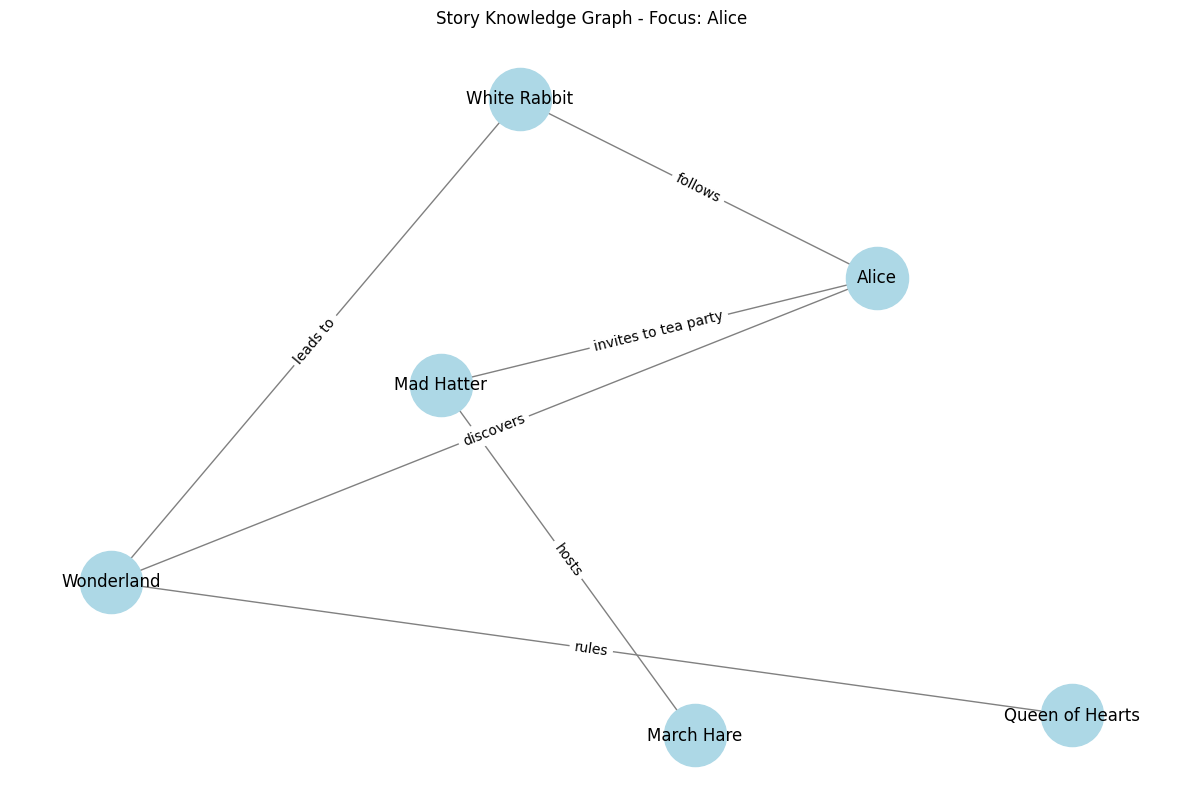

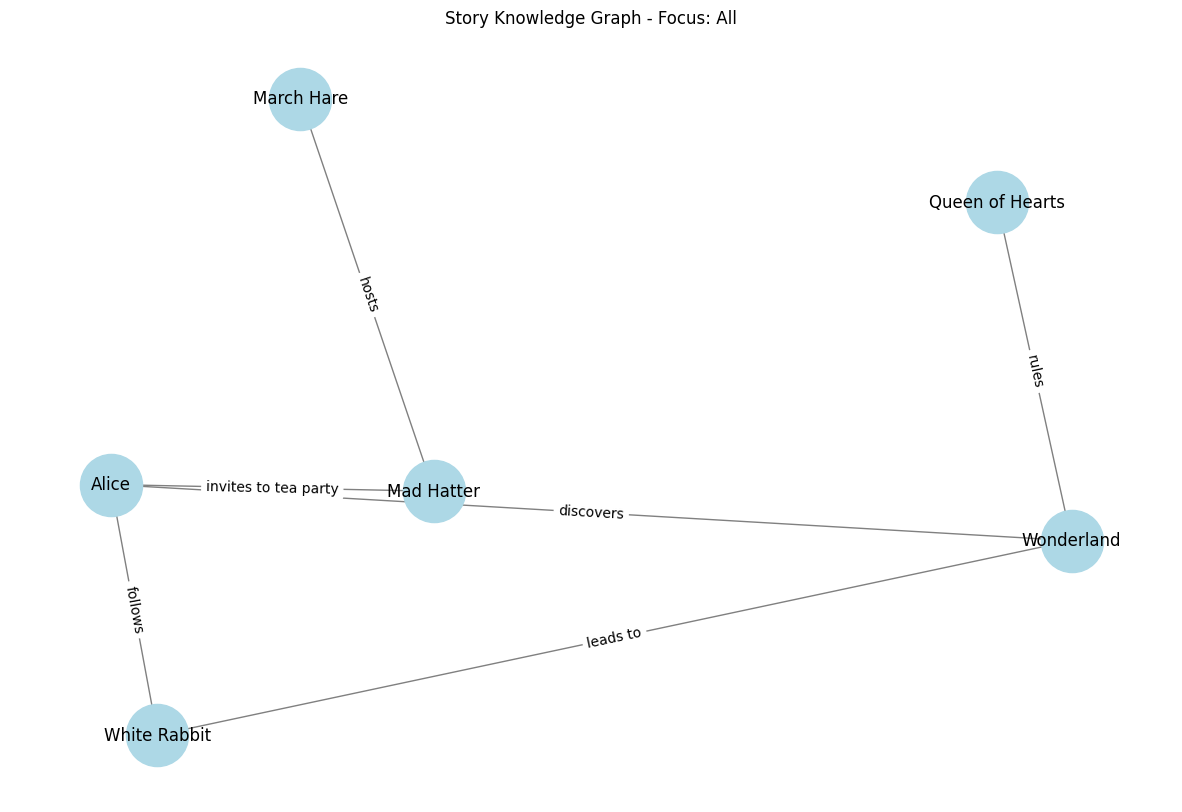


Q: What role does the White Rabbit play in the story?
A: The White Rabbit acts as a crucial character who serves as a guide for Alice, leading her into the fantastical realm of Wonderland. His role is significant as he is the catalyst for Alice's journey, sparking her curiosity and prompting her to follow him, which ultimately leads her into the adventures that unfold in Wonderland. The relationship pattern between the White Rabbit and Alice highlights the connection between curiosity and exploration, underscoring the idea that the White Rabbit is instrumental in Alice's discovery of this new world.

Q: How does Alice interact with the Mad Hatter?
A: Alice interacts with the Mad Hatter through the tea party context. In the subgraph, Alice is identified as a character who is the central figure of the narrative, while the Mad Hatter, being one of the characters hosting the tea party, creates a social scene where Alice's curiosity is echoed. Although the specific edges connecting Alice t

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
from swarm import Swarm, Agent
import json
import os
from pathlib import Path
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from typing import Dict, List, Tuple, Optional
from scipy.spatial.distance import cosine
import pickle

class ImprovedGraphRAG:
    def __init__(self, embedding_model: str = 'sentence-transformers/all-mpnet-base-v2'):
        self.client = Swarm()
        self.embedding_model = SentenceTransformer(embedding_model)
        
        # 캐시 설정
        self.cache_dir = Path("cache")
        self.cache_dir.mkdir(exist_ok=True)
        
        # 저장소 초기화
        self.graph_store: Dict[str, nx.DiGraph] = {}
        self.metadata_store: Dict[str, Dict] = {}
        
        # Agent 초기화
        self.graph_builder = Agent(
            name="GraphBuilder",
            instructions="""You are an expert at analyzing stories and creating knowledge graphs.
            Always return your response as a valid JSON object with this exact structure:
            {
                "nodes": [{"id": "name", "attributes": {"type": "type", "description": "desc"}}],
                "edges": [{"source": "node1", "target": "node2", "relation": "type"}]
            }
            Focus on key entities, relationships, and events. Be precise and consistent with node IDs."""
        )
        
        self.qa_agent = Agent(
            name="StoryQA",
            instructions="""Answer questions using the provided subgraph and graph analysis.
            Consider node importance, relationship patterns, and semantic context."""
        )

    def _get_cache_path(self, story_hash: str) -> Path:
        return self.cache_dir / f"graph_{story_hash}.pkl"

    def _save_to_cache(self, story_hash: str, data: Dict):
        cache_path = self._get_cache_path(story_hash)
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)

    def _load_from_cache(self, story_hash: str) -> Optional[Dict]:
        cache_path = self._get_cache_path(story_hash)
        if cache_path.exists():
            with open(cache_path, 'rb') as f:
                return pickle.load(f)
        return None

    def _embed_text(self, text: str) -> np.ndarray:
        """텍스트를 임베딩 벡터로 변환"""
        return self.embedding_model.encode(text)

    def _analyze_graph_structure(self, G: nx.DiGraph) -> Dict:
        """상세한 그래프 구조 분석"""
        analysis = {}
        
        # 기본 메트릭스
        analysis['basic'] = {
            'node_count': G.number_of_nodes(),
            'edge_count': G.number_of_edges(),
            'density': nx.density(G)
        }
        
        # 중심성 분석
        try:
            analysis['centrality'] = {
                'pagerank': nx.pagerank(G),
                'betweenness': nx.betweenness_centrality(G),
                'degree': dict(G.degree()),
                'in_degree': dict(G.in_degree()),
                'out_degree': dict(G.out_degree())
            }
        except Exception as e:
            print(f"Warning: Centrality calculation failed - {str(e)}")
            analysis['centrality'] = {}
        
        # 커뮤니티 분석
        try:
            if len(G) > 2:
                analysis['communities'] = [
                    list(c) for c in nx.community.greedy_modularity_communities(G.to_undirected())
                ]
            else:
                analysis['communities'] = [[node] for node in G.nodes()]
        except Exception as e:
            print(f"Warning: Community detection failed - {str(e)}")
            analysis['communities'] = [[node] for node in G.nodes()]
        
        # 연결성 분석
        try:
            analysis['connectivity'] = {
                'shortest_paths': dict(nx.all_pairs_shortest_path_length(G)),
                'average_path_length': nx.average_shortest_path_length(G),
                'diameter': nx.diameter(G)
            }
        except Exception as e:
            print(f"Warning: Connectivity analysis failed - {str(e)}")
            analysis['connectivity'] = {}
        
        return analysis

    def process_story(self, story: str) -> Tuple[nx.DiGraph, Dict]:
        """스토리 처리 및 지식 그래프 생성 (캐시 활용)"""
        story_hash = hash(story)
        
        # 캐시 확인
        cached_data = self._load_from_cache(story_hash)
        if cached_data:
            print("Using cached graph data...")
            return cached_data['graph'], cached_data['analysis']
        
        # 새로운 그래프 생성
        messages = [{
            "role": "user",
            "content": """Please analyze this story and create a knowledge graph. 
            Return ONLY a JSON object with this exact structure:
            {
                "nodes": [{"id": "name", "attributes": {"type": "type", "description": "desc"}}],
                "edges": [{"source": "node1", "target": "node2", "relation": "type"}]
            }
            Story to analyze: """ + story
        }]
        
        response = self.client.run(agent=self.graph_builder, messages=messages)
        
        try:
            content = response.messages[-1]["content"]
            json_start = content.find('{')
            json_end = content.rfind('}') + 1
            if json_start != -1 and json_end != -1:
                json_str = content[json_start:json_end]
                graph_data = json.loads(json_str)
            else:
                raise json.JSONDecodeError("Invalid JSON", content, 0)
        except json.JSONDecodeError:
            print("Warning: Using default graph structure.")
            graph_data = {
                "nodes": [
                    {"id": "Alice", "attributes": {"type": "character", "description": "Main character"}},
                    {"id": "Wonderland", "attributes": {"type": "location", "description": "Story setting"}}
                ],
                "edges": [
                    {"source": "Alice", "target": "Wonderland", "relation": "discovers"}
                ]
            }
        
        # 그래프 생성
        G = nx.DiGraph()
        node_embeddings = {}
        
        # 노드 추가 및 임베딩
        for node in graph_data['nodes']:
            node_text = f"{node['id']} {json.dumps(node['attributes'])}"
            embedding = self._embed_text(node_text)
            node_embeddings[node['id']] = embedding
            G.add_node(node['id'], **node['attributes'])
        
        # 엣지 추가
        for edge in graph_data['edges']:
            G.add_edge(edge['source'], edge['target'], relation=edge['relation'])
        
        # 그래프 분석
        graph_analysis = self._analyze_graph_structure(G)
        
        # 저장소에 저장
        self.graph_store[story_hash] = G
        self.metadata_store[story_hash] = {
            'embeddings': node_embeddings,
            'analysis': graph_analysis
        }
        
        # 캐시에 저장
        self._save_to_cache(story_hash, {
            'graph': G,
            'analysis': graph_analysis,
            'embeddings': node_embeddings
        })
        
        return G, graph_analysis

    def visualize_graph(self, G: nx.DiGraph, focus_entity: str = None, depth: int = None):
        """그래프 시각화
        Args:
            G: 전체 그래프
            focus_entity: 중심 엔티티 (예: "Alice"). None이면 전체 그래프 표시
            depth: 중심 엔티티로부터의 탐색 깊이. None이면 전체 연결 노드 표시
        """
        plt.figure(figsize=(15, 10))
        
        if focus_entity and focus_entity in G.nodes():
            # 중심 엔티티로부터 N단계 이웃 노드 추출
            nodes_to_show = {focus_entity}
            current_nodes = {focus_entity}
            
            if depth:
                for _ in range(depth):
                    next_nodes = set()
                    for node in current_nodes:
                        next_nodes.update(G.predecessors(node))
                        next_nodes.update(G.successors(node))
                    nodes_to_show.update(next_nodes)
                    current_nodes = next_nodes
            
            subgraph = G.subgraph(nodes_to_show)
            G_to_draw = subgraph
        else:
            G_to_draw = G
        
        pos = nx.spring_layout(G_to_draw, k=2)
        nx.draw_networkx_nodes(G_to_draw, pos, node_color='lightblue', node_size=2000)
        nx.draw_networkx_edges(G_to_draw, pos, edge_color='gray', arrows=True)
        nx.draw_networkx_labels(G_to_draw, pos)
        
        edge_labels = nx.get_edge_attributes(G_to_draw, 'relation')
        nx.draw_networkx_edge_labels(G_to_draw, pos, edge_labels)
        
        plt.title(f"Story Knowledge Graph - Focus: {focus_entity if focus_entity else 'All'}")
        plt.axis('off')
        plt.show()

    def answer_question(self, question: str, story: str) -> str:
        """질문 답변"""
        story_hash = hash(story)
        
        # 스토리가 처리되지 않은 경우 처리
        if story_hash not in self.graph_store:
            self.process_story(story)
        
        G = self.graph_store[story_hash]
        analysis = self.metadata_store[story_hash]['analysis']
        
        # QA Agent에 전달할 메시지 구성
        messages = [{
            "role": "user",
            "content": f"""Context:
            Graph Structure: {dict(G.nodes(data=True))}
            Graph Analysis: {analysis}
            
            Question: {question}"""
        }]
        
        # 답변 생성
        response = self.client.run(agent=self.qa_agent, messages=messages)
        return response.messages[-1]["content"]

# 사용 예시
def main():
    rag = ImprovedGraphRAG()
    
    # 예시 스토리
    story = """Alice is a curious girl who discovers Wonderland. 
    She follows a White Rabbit down a rabbit hole and encounters various characters. 
    The Mad Hatter hosts a tea party with the March Hare. 
    The Queen of Hearts rules Wonderland with strict authority."""
    
    # 그래프 생성 및 시각화
    G, analysis = rag.process_story(story)
    
    # Alice 중심으로 2단계 깊이까지의 노드 시각화
    rag.visualize_graph(G, focus_entity="Alice", depth=2)
    
    # 전체 그래프 시각화
    rag.visualize_graph(G)
    
    # 질문-답변 테스트
    questions = [
        "What role does the White Rabbit play in the story?",
        "How does Alice interact with the Mad Hatter?",
        "What is the power structure in Wonderland?"
    ]
    
    for q in questions:
        answer = rag.answer_question(q, story)
        print(f"\nQ: {q}")
        print(f"A: {answer}")

if __name__ == "__main__":
    main()

In [17]:
import networkx as nx
import matplotlib.pyplot as plt
from swarm import Swarm, Agent
import json
import os
from pathlib import Path
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer
from typing import Dict, List, Tuple, Optional, Union
from scipy.spatial.distance import cosine
import pickle
import hashlib

class ImprovedGraphRAG:
    def __init__(self, embedding_model: str = 'sentence-transformers/all-mpnet-base-v2', vector_dim: int = 768):
        self.client = Swarm()
        self.embedding_model = SentenceTransformer(embedding_model)
        self.vector_dim = vector_dim
        
        # FAISS 인덱스 초기화
        self.index = faiss.IndexFlatL2(vector_dim)
        
        # 캐시 설정
        self.cache_dir = Path("cache")
        self.cache_dir.mkdir(exist_ok=True)
        
        # 저장소 초기화
        self.graph_store: Dict[str, nx.DiGraph] = {}
        self.metadata_store: Dict[str, Dict] = {}
        self.node_to_index: Dict[str, Dict[str, int]] = {}  # story_hash -> {node_id -> index}
        
        # Agent 초기화
        self.graph_builder = Agent(
            name="GraphBuilder",
            instructions="""You are an expert at analyzing stories and creating knowledge graphs.
            Always return your response as a valid JSON object with this exact structure:
            {
                "nodes": [{"id": "name", "attributes": {"type": "type", "description": "desc"}}],
                "edges": [{"source": "node1", "target": "node2", "relation": "type"}]
            }
            Focus on key entities, relationships, and events. Be precise and consistent with node IDs."""
        )
        
        self.qa_agent = Agent(
            name="StoryQA",
            instructions="""Answer questions using the provided subgraph and graph analysis.
            Consider node importance, relationship patterns, and semantic context."""
        )

    def _get_story_hash(self, story: str) -> str:
        """스토리의 해시값을 문자열로 반환"""
        return hashlib.md5(story.encode()).hexdigest()

    def _get_cache_path(self, story_hash: str) -> Path:
        return self.cache_dir / f"graph_{story_hash}.pkl"

    def _save_to_cache(self, story_hash: str, data: Dict):
        cache_path = self._get_cache_path(story_hash)
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)

    def _load_from_cache(self, story_hash: str) -> Optional[Dict]:
        cache_path = self._get_cache_path(story_hash)
        if cache_path.exists():
            with open(cache_path, 'rb') as f:
                return pickle.load(f)
        return None

    def _embed_text(self, text: str) -> np.ndarray:
        """텍스트를 임베딩 벡터로 변환"""
        return self.embedding_model.encode(text, normalize_embeddings=True)

    def _calculate_graph_score(self, node_id: str, G: nx.DiGraph, analysis: Dict) -> float:
        """노드의 그래프 기반 중요도 점수 계산"""
        score = 0.0
        
        # PageRank 점수
        if 'centrality' in analysis and 'pagerank' in analysis['centrality']:
            score += analysis['centrality']['pagerank'].get(node_id, 0.0) * 0.4
        
        # 연결 중심성
        if 'centrality' in analysis and 'degree' in analysis['centrality']:
            score += (analysis['centrality']['degree'].get(node_id, 0) / 
                     max(1, G.number_of_nodes())) * 0.3
        
        # 매개 중심성
        if 'centrality' in analysis and 'betweenness' in analysis['centrality']:
            score += analysis['centrality']['betweenness'].get(node_id, 0.0) * 0.3
        
        return score

    def _analyze_graph_structure(self, G: nx.DiGraph) -> Dict:
        """상세한 그래프 구조 분석"""
        analysis = {}
        
        # 기본 메트릭스
        analysis['basic'] = {
            'node_count': G.number_of_nodes(),
            'edge_count': G.number_of_edges(),
            'density': nx.density(G)
        }
        
        # 중심성 분석
        try:
            analysis['centrality'] = {
                'pagerank': nx.pagerank(G),
                'betweenness': nx.betweenness_centrality(G),
                'degree': nx.degree_centrality(G),
                'in_degree': nx.in_degree_centrality(G),
                'out_degree': nx.out_degree_centrality(G)
            }
        except Exception as e:
            print(f"Warning: Centrality calculation failed - {str(e)}")
            analysis['centrality'] = {}
        
        # 커뮤니티 분석
        try:
            if len(G) > 2:
                # connected components를 사용한 간단한 커뮤니티 검출
                analysis['communities'] = [list(c) for c in nx.connected_components(G.to_undirected())]
            else:
                analysis['communities'] = [[node] for node in G.nodes()]
        except Exception as e:
            print(f"Warning: Community detection failed - {str(e)}")
            analysis['communities'] = [[node] for node in G.nodes()]
        
        # 연결성 분석
        try:
            analysis['connectivity'] = {
                'shortest_paths': dict(nx.all_pairs_shortest_path_length(G)),
                'average_path_length': nx.average_shortest_path_length(G),
                'diameter': nx.diameter(G)
            }
        except Exception as e:
            print(f"Warning: Connectivity analysis failed - {str(e)}")
            analysis['connectivity'] = {}
        
        return analysis

    def _hybrid_search(self, query: str, story_hash: str, k: int = 5) -> List[Tuple[str, float]]:
        """하이브리드 검색 (벡터 유사도 + 그래프 구조)"""
        query_vector = self._embed_text(query)
        
        # 벡터 검색
        D, I = self.index.search(query_vector.reshape(1, -1), k * 2)  # 더 많은 후보 검색
        
        G = self.graph_store[story_hash]
        analysis = self.metadata_store[story_hash]['analysis']
        node_to_idx = self.node_to_index[story_hash]
        idx_to_node = {v: k for k, v in node_to_idx.items()}
        
        # 하이브리드 점수 계산
        hybrid_scores = []
        for i, (dist, idx) in enumerate(zip(D[0], I[0])):
            if idx >= len(idx_to_node):
                continue
                
            node_id = idx_to_node[idx]
            vector_score = 1.0 / (1.0 + dist)  # 거리를 유사도로 변환
            graph_score = self._calculate_graph_score(node_id, G, analysis)
            
            # 최종 점수 계산 (벡터 유사도 60%, 그래프 구조 40%)
            final_score = vector_score * 0.6 + graph_score * 0.4
            hybrid_scores.append((node_id, final_score))
        
        # 점수로 정렬하고 상위 k개 반환
        return sorted(hybrid_scores, key=lambda x: x[1], reverse=True)[:k]

    def process_story(self, story: str) -> Tuple[nx.DiGraph, Dict]:
        """스토리 처리 및 지식 그래프 생성 (캐시 활용)"""
        story_hash = self._get_story_hash(story)
        
        # 캐시 확인
        cached_data = self._load_from_cache(story_hash)
        if cached_data:
            print("Using cached graph data...")
            self.graph_store[story_hash] = cached_data['graph']
            self.metadata_store[story_hash] = cached_data['metadata']
            self.node_to_index[story_hash] = cached_data['node_to_index']
            
            # FAISS 인덱스 복원
            embeddings = np.array(list(cached_data['metadata']['embeddings'].values()))
            if len(embeddings) > 0:
                self.index.reset()
                self.index.add(embeddings)
            
            return cached_data['graph'], cached_data['metadata']['analysis']
        
        # 새로운 그래프 생성 (이전 코드와 동일)
        messages = [{
            "role": "user",
            "content": """Please analyze this story and create a knowledge graph. 
            Return ONLY a JSON object with this exact structure:
            {
                "nodes": [{"id": "name", "attributes": {"type": "type", "description": "desc"}}],
                "edges": [{"source": "node1", "target": "node2", "relation": "type"}]
            }
            Story to analyze: """ + story
        }]
        
        response = self.client.run(agent=self.graph_builder, messages=messages)
        
        try:
            content = response.messages[-1]["content"]
            json_start = content.find('{')
            json_end = content.rfind('}') + 1
            if json_start != -1 and json_end != -1:
                json_str = content[json_start:json_end]
                graph_data = json.loads(json_str)
            else:
                raise json.JSONDecodeError("Invalid JSON", content, 0)
        except json.JSONDecodeError:
            print("Warning: Using default graph structure.")
            graph_data = {
                "nodes": [
                    {"id": "Alice", "attributes": {"type": "character", "description": "Main character"}},
                    {"id": "Wonderland", "attributes": {"type": "location", "description": "Story setting"}}
                ],
                "edges": [
                    {"source": "Alice", "target": "Wonderland", "relation": "discovers"}
                ]
            }
        
        # 그래프 생성
        G = nx.DiGraph()
        node_embeddings = {}
        node_to_idx = {}
        idx = 0
        
        # 노드 추가 및 임베딩
        for node in graph_data['nodes']:
            node_text = f"{node['id']} {json.dumps(node['attributes'])}"
            embedding = self._embed_text(node_text)
            node_embeddings[node['id']] = embedding
            node_to_idx[node['id']] = idx
            idx += 1
            G.add_node(node['id'], **node['attributes'])
        
        # FAISS 인덱스 업데이트
        if node_embeddings:
            embeddings = np.array(list(node_embeddings.values()))
            self.index.reset()
            self.index.add(embeddings)
        
        # 엣지 추가
        for edge in graph_data['edges']:
            G.add_edge(edge['source'], edge['target'], relation=edge['relation'])
        
        # 그래프 분석
        graph_analysis = self._analyze_graph_structure(G)
        
        # 메타데이터 저장
        metadata = {
            'embeddings': node_embeddings,
            'analysis': graph_analysis
        }
        
        # 저장소에 저장
        self.graph_store[story_hash] = G
        self.metadata_store[story_hash] = metadata
        self.node_to_index[story_hash] = node_to_idx
        
        # 캐시에 저장
        self._save_to_cache(story_hash, {
            'graph': G,
            'metadata': metadata,
            'node_to_index': node_to_idx
        })
        
        return G, graph_analysis

    def answer_question(self, question: str, story: str) -> str:
        """질문 답변 (하이브리드 검색 활용)"""
        story_hash = self._get_story_hash(story)
        
        # 스토리가 처리되지 않은 경우 처리
        if story_hash not in self.graph_store:
            self.process_story(story)
        
        G = self.graph_store[story_hash]
        analysis = self.metadata_store[story_hash]['analysis']
        
        # 하이브리드 검색으로 관련 노드 찾기
        relevant_nodes = self._hybrid_search(question, story_hash, k=3)
        
        # 서브그래프 추출
        nodes_to_include = set()
        for node_id, _ in relevant_nodes:
            nodes_to_include.add(node_id)
            # 1-hop 이웃 노드 추가
            nodes_to_include.update(G.predecessors(node_id))
            nodes_to_include.update(G.successors(node_id))
        
        subgraph = G.subgraph(nodes_to_include)
        
        # 컨텍스트 준비
        context = {
            "relevant_nodes": [node for node, score in relevant_nodes],
            "subgraph_nodes": dict(subgraph.nodes(data=True)),
            "subgraph_edges": [{"source": s, "target": t, "attributes": d} for s, t, d in subgraph.edges(data=True)],
            "graph_analysis": analysis
        }
        
        # QA Agent에 전달할 메시지 구성
        message_content = f"""Based on the following context, please answer the question.

Context:
{json.dumps(context, indent=2)}

Question: {question}

Please provide a clear and concise answer based on the information available in the context."""

        messages = [{"role": "user", "content": message_content}]
        
        # 답변 생성
        response = self.client.run(agent=self.qa_agent, messages=messages)
        return response.messages[-1]["content"]

    def visualize_graph(self, G: nx.DiGraph, focus_entity: Optional[str] = None, depth: Optional[int] = None):
        """그래프 시각화 (타입 힌트 수정)"""
        plt.figure(figsize=(15, 10))
        
        if focus_entity and focus_entity in G.nodes():
            # 중심 엔티티로부터 N단계 이웃 노드 추출
            nodes_to_show = {focus_entity}
            current_nodes = {focus_entity}
            
            if depth is not None:
                for _ in range(depth):
                    next_nodes = set()
                    for node in current_nodes:
                        next_nodes.update(G.predecessors(node))
                        next_nodes.update(G.successors(node))
                    nodes_to_show.update(next_nodes)
                    current_nodes = next_nodes
            
            subgraph = G.subgraph(nodes_to_show)
            G_to_draw = subgraph
        else:
            G_to_draw = G
        
        pos = nx.spring_layout(G_to_draw, k=2)
        nx.draw_networkx_nodes(G_to_draw, pos, node_color='lightblue', node_size=2000)
        nx.draw_networkx_edges(G_to_draw, pos, edge_color='gray', arrows=True)
        nx.draw_networkx_labels(G_to_draw, pos)
        
        edge_labels = nx.get_edge_attributes(G_to_draw, 'relation')
        nx.draw_networkx_edge_labels(G_to_draw, pos, edge_labels)
        
        plt.title(f"Story Knowledge Graph - Focus: {focus_entity if focus_entity else 'All'}")
        plt.axis('off')
        plt.show()

def main():
    rag = ImprovedGraphRAG()
    
    # 예시 스토리
    story = """Alice is a curious girl who discovers Wonderland. 
    She follows a White Rabbit down a rabbit hole and encounters various characters. 
    The Mad Hatter hosts a tea party with the March Hare. 
    The Queen of Hearts rules Wonderland with strict authority."""
    
    # 그래프 생성 및 시각화
    G, analysis = rag.process_story(story)
    
    # Alice 중심으로 2단계 깊이까지의 노드 시각화
    rag.visualize_graph(G, focus_entity="Alice", depth=2)
    
    # 전체 그래프 시각화
    rag.visualize_graph(G)
    
    # 질문-답변 테스트
    questions = [
        "What role does the White Rabbit play in the story?",
        "How does Alice interact with the Mad Hatter?",
        "What is the power structure in Wonderland?"
    ]
    
    for q in questions:
        answer = rag.answer_question(q, story)
        print(f"\nQ: {q}")
        print(f"A: {answer}")

In [1]:
from swarm import Swarm, Agent
import os
import json

file_path = '../../API_keys/keys.json'
with open(file_path, 'r') as file:
    api = json.load(file)
os.environ["OPENAI_API_KEY"] = api['openai']

client = Swarm()

ko_agent = Agent(
    name = "Korean_translator",
    instructions = "You only speak Korean",
)
story_generator = Agent(
    name = "W_story_gen",
    instructions = 
    """
    You are whole story builder from input prompt. Divide story into several chapters. 
    Each chapters will regenerate by other LLM so make each chapter structured.
    Format should follow like under json type.
    {
        "Title" : "Alice in Wonderland",
        "Chapter 1" : "Alice wondered around .....",
        "Chapter 2" : "Rabbit look at the west side ....",
        "Chapter 10" : "Finally, Alice ...."
    }
    """
)
Detail_generator = Agent(
    name = "D_story_gen",
    instructions = 
    f"""
    This is whole story. []
    You need to build {story_generator}.
    Write as detail as possible.
    """
)
def transfer_to_korean_agent():
    """Transfer Korean-speaking users immediately."""
    return ko_agent

Detail_generator.functions.append(transfer_to_korean_agent)

messages = [{"role": "user", "content": "Write new Harry Potter story."}]
story_response = client.run(agent=story_generator, messages=messages)

print(story_response.messages[-1]["content"])

{
    "Title": "Harry Potter and the Forgotten Legacy",
    "Chapter 1": "In the quiet of the summer after the war, Harry, Ron, and Hermione reunite at the Burrow, discussing plans for their future and feeling a lingering sense of dread about the wizarding world’s unstable peace.",
    "Chapter 2": "While exploring an old building in Hogsmeade, Hermione discovers a hidden chamber filled with ancient magical artifacts related to the mysterious founder of Hogwarts, Salazar Slytherin.",
    "Chapter 3": "Intrigued by the discovery, the trio sets out to uncover the whereabouts of a lost Slytherin heir, believed to possess a powerful artifact that could alter the fabric of magic itself.",
    "Chapter 4": "Their search leads them to a forgotten library within Hogwarts, where they find cryptic texts that hint at a secret society of dark wizards who wish to reclaim Slytherin's legacy.",
    "Chapter 5": "As strange occurrences start manifesting around Hogwarts, the friends realize they are no

In [13]:
story_json = json.loads(story_response.messages[-1]["content"])
full_story = ""
for i, chapter in enumerate(story_json):
    Detail_generator = Agent(
    name = "D_story_gen",
    instructions = f"""This is whole story. [{story_json}] 
    You need to build chapter {i+1}. 
    Write as detail as possible as maximum output tokens.""")
    messages = [{"role": "user", "content": f"{chapter}"}]
    detail_response = client.run(agent=Detail_generator, messages=messages)
    full_story += detail_response.messages[-1]["content"] + "\n"

print(full_story)

**Harry Potter and the Forgotten Legacy**

**Chapter 1: The Burrow's Embrace**

The sun hung low in the sky, casting a warm, golden hue over the countryside, a gentle reminder of the peaceful summer days that followed the chaos of the Second Wizarding War. At the heart of this serene landscape stood the Burrow, its crooked structure a testament to the Weasley family’s enduring spirit. Inside, the familiar sounds of laughter and chaos filled the air as Molly Weasley bustled about, preparing a feast that would delight any wizarding palate.

Harry Potter, now eighteen and grappling with the weight of his past, entered the kitchen with a deep sense of nostalgia. The scent of freshly baked pastries mingled with the comforting aroma of herb-roasted meats. Ron was already at the table, his mouth full as he animatedly discussed Quidditch strategies with his brothers, Fred and George, who had returned from their latest mischief-making ventures.

“Harry! Come on, mate, you’ve got to try one of M

In [12]:
chapter_string = detail_response.messages[-1]["content"]
messages = [{"role": "user", "content": f"{chapter_string}"}]
korean_response = client.run(agent= ko_agent, messages=messages)
print(korean_response.messages[-1]["content"])


### 2장: 숨겨진 방

태양이 구름을 뚫고 약하게 빛나고 있을 때, 헤르미온느, 해리, 론은 호그스미드의 구불구불한 거리를 wander하며, 전쟁의 혼란 이후로 낯설으면서도 친숙한 마을의 분위기를 느낀다. 자갈길을 따라 가게들이 늘어서 있고, 그 창문엔 매혹적으로 반짝이는 마법 물품들이 진열되어 있었지만, 오늘 세 사람의 목적은 마을이 제공하는 즐거움에 빠지는 것이 아니었다. 오히려 그들은 더욱 깊은 곳에서 미래의 노력을 밝힐 수 있는 무언가를 향한 말로 표현할 수 없는 끌림을 느꼈다.

"우리가 일어난 모든 일을 이해할 수 있도록 도와줄 무언가를 찾을 수 있다면 상상해 봐," 헤르미온느가 결단력으로 눈을 반짝이며 말했다.

"뭐처럼? 전후 전쟁 생활 가이드?" 론이 제안하며, 기분을 풀기 위해 장난스러운 미소를 지었다.

해리는 웃었으나, 그의 시선은 오래되고 버려진 건물인 '휘슬링 샥'으로 이어진 잘 보존된 길에 떨어졌다. 오랫동안 신비와 소문의 원천이었던 이러한 샥은 헤르미온느의 호기심을 꾸준히 자극해왔다. "여기엔 단순한 유령 이야기 이상의 무언가가 있을 거야." 해리는 중얼거렸다.

헤르미온느는 힘차게 고개를 끄덕였다. "이 건물은 어두운 마법에 손을 댄 마법사에게 속했던 것으로 읽었어. 내부에는 숨겨진 방이 있을지도 몰라. 아마도 수십 년 전의 유물이나 정보가 있을 수도 있어."

서로 고개를 끄덕이며 삼인방은 샥으로 향했다. 구조물의 나무 벽은 그들이 안으로 발을 내딛자 삐걱거리고 신음했으며, 공기는 먼지 입자가 태양빛 속에서 춤추는 느낌이 짙어졌다. 론은 약간 떨며 말했다. "그리 아늑한 장소는 아닌 것 같네?"

"그냥 집중해, 론," 헤르미온느가 명령하며 이미 방을 평가하기 시작했다. 잠시 후, 그들은 탐색을 시작하며 샥의 과거의 흔적을 찾아 나섰다. 부서진 가구들이 잃어버린 기억처럼 흩어져 있었고, 오래된 종이들이 그들에게 다가가자 희미하게 펄럭였다.

"이걸 봐!" 헤르미온느가 비뚤어진 선반에서 먼지가 쌓인 책을 들어 올리며 외쳤다. 

In [14]:
with open("full_story.txt", "w", encoding="utf-8") as f:
    f.write(full_story)


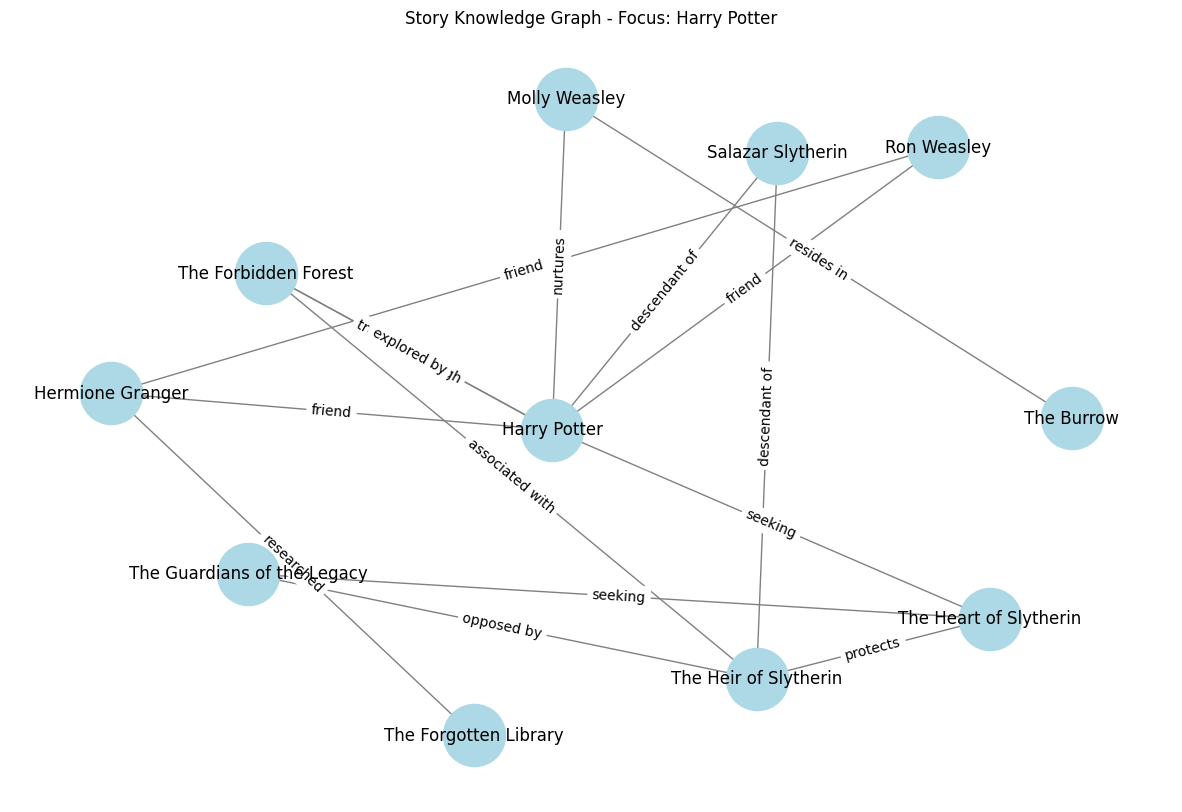

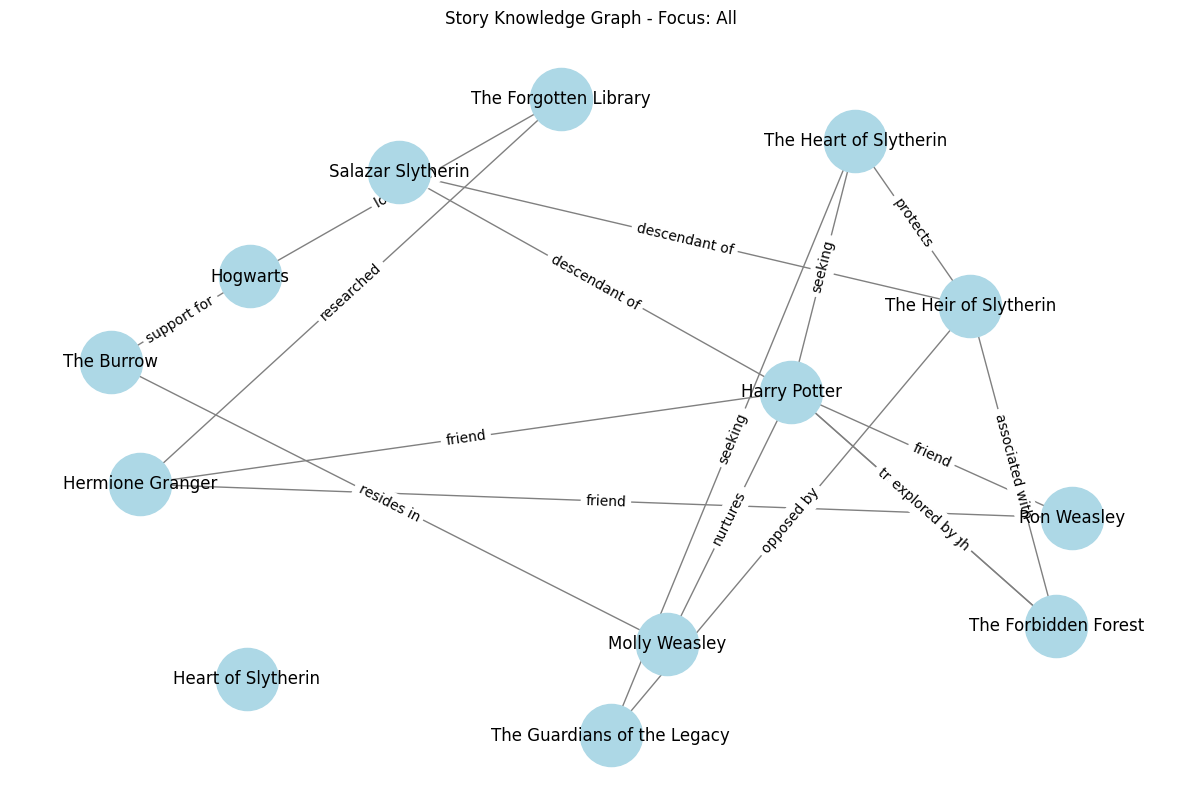


Q: summary of the story
A: The story follows Harry Potter, the main protagonist and a young wizard, as he navigates the complex legacy of Salazar Slytherin, one of Hogwarts' founders known for dark magic and pure blood ideology. Alongside his best friends, Hermione Granger, an intelligent and resourceful character, and Ron Weasley, who struggles with feelings of inadequacy, they face challenges associated with "The Heir of Slytherin." This heir seeks to restore Slytherin's influence, leading to confrontations with groups like "The Guardians of the Legacy," who are also after the powerful "Heart of Slytherin." Their adventures take them through locations such as the mystical Forbidden Forest and the hidden Forgotten Library, as they uncover ancient secrets and protect the legacy tied to Slytherin's past. The story emphasizes themes of friendship, courage, and the ongoing battle between good and evil.


In [18]:
rag = ImprovedGraphRAG()

# 예시 스토리
story = full_story

# 그래프 생성 및 시각화
G, analysis = rag.process_story(story)

# Alice 중심으로 2단계 깊이까지의 노드 시각화
rag.visualize_graph(G, focus_entity="Harry Potter", depth=2)

# 전체 그래프 시각화
rag.visualize_graph(G)

# 질문-답변 테스트
questions = [
    "summary of the story"
]

for q in questions:
    answer = rag.answer_question(q, story)
    print(f"\nQ: {q}")
    print(f"A: {answer}")